In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../../libTLDA/

/atlas/u/kechoi/libTLDA


# Dataset

In [26]:
from libtlda.iw import ImportanceWeightedClassifier

In [27]:
X = np.random.randn(10, 2)
y = np.hstack((-np.ones((5,)), np.ones((5,))))
Z = np.random.randn(10, 2)

In [28]:
y.shape

(10,)

In [29]:
clf = ImportanceWeightedClassifier(weight_estimator='kmm')

In [30]:
clf.fit(X, y, Z)
u_pred = clf.predict(Z)

     pcost       dcost       gap    pres   dres
 0:  2.7355e+01 -1.7808e+01  1e+02  3e-01  2e+00
 1:  3.3294e+01  1.3696e+01  2e+01  9e-17  5e-16
 2:  2.9669e+01  2.5907e+01  4e+00  6e-17  4e-16
 3:  2.7687e+01  2.7098e+01  6e-01  2e-16  6e-16
 4:  2.7234e+01  2.7205e+01  3e-02  7e-17  4e-15
 5:  2.7208e+01  2.7208e+01  3e-04  9e-17  9e-14
 6:  2.7208e+01  2.7208e+01  3e-06  6e-17  7e-14
Optimal solution found.


----

# Given example in repo

In [108]:
import numpy as np
import numpy.random as rnd

from sklearn.linear_model import LogisticRegression
from libtlda.iw import ImportanceWeightedClassifier

"""Generate synthetic data set"""

# Sample sizes
N = 1000
M = 1000

# Class properties
labels = [0, 1]
nK = 2

# Dimensionality
D = 2

# Source domain
pi_S = [1./2, 1./2]
si_S = 1.0
N0 = int(np.round(N*pi_S[0]))
N1 = N - N0
X0 = rnd.randn(N0, D)*si_S + (-2, 0)
X1 = rnd.randn(N1, D)*si_S + (+2, 0)
X = np.concatenate((X0, X1), axis=0)
y = np.concatenate((labels[0]*np.ones((N0,), dtype='int'),
                    labels[1]*np.ones((N1,), dtype='int')), axis=0)

# Target domain
pi_T = [1./2, 1./2]
si_T = 3.0
M0 = int(np.round(M*pi_T[0]))
M1 = M - M0
Z0 = rnd.randn(M0, D)*si_T + (-2, -2)
Z1 = rnd.randn(M1, D)*si_T + (+2, +2)
Z = np.concatenate((Z0, Z1), axis=0)
u = np.concatenate((labels[0]*np.ones((M0,), dtype='int'),
                    labels[1]*np.ones((M1,), dtype='int')), axis=0)

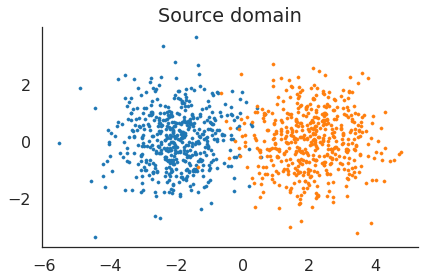

In [109]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], s=10)
plt.scatter(X[:,0][y==1], X[:,1][y==1], s=10)

plt.title('Source domain')
sns.despine()
plt.tight_layout()

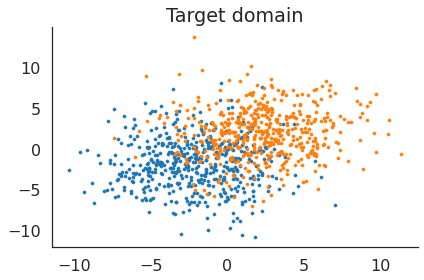

In [110]:
plt.scatter(Z[:,0][u==0], Z[:,1][u==0], s=10)
plt.scatter(Z[:,0][u==1], Z[:,1][u==1], s=10)

plt.title('Target domain')
sns.despine()
plt.tight_layout()

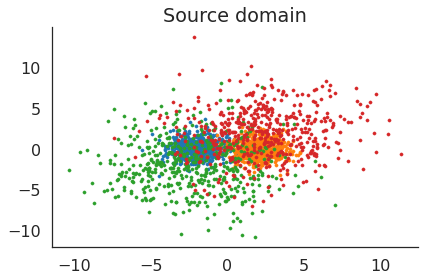

In [111]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], s=10)
plt.scatter(X[:,0][y==1], X[:,1][y==1], s=10)
plt.scatter(Z[:,0][u==0], Z[:,1][u==0], s=10)
plt.scatter(Z[:,0][u==1], Z[:,1][u==1], s=10)

plt.title('Target domain')
sns.despine()
plt.tight_layout()

plt.title('Source domain')
sns.despine()
plt.tight_layout()

In [122]:
# # can we save this data?
np.savez('/atlas/u/kechoi/multi-fairgen/data/kmm/source', **{'x': X, 'y': y})
np.savez('/atlas/u/kechoi/multi-fairgen/data/kmm/target', **{'x': Z, 'y': u})

In [121]:
# Train via KMM
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=7)
clf.fit(X, y, Z)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  3.9334e+05  9.4215e+05  4e+08  1e+01  7e-01
 1:  1.3508e+06  7.2059e+05  5e+06  2e-01  8e-03
 2:  1.3725e+06  8.6567e+05  5e+05  1e-16  3e-12
 3:  1.3722e+06  1.3288e+06  4e+04  4e-16  2e-13
 4:  1.3622e+06  1.3303e+06  3e+04  9e-17  1e-11
 5:  1.3563e+06  1.3428e+06  1e+04  8e-16  7e-12
 6:  1.3520e+06  1.3450e+06  7e+03  9e-16  4e-11
 7:  1.3487e+06  1.3466e+06  2e+03  4e-16  2e-11
 8:  1.3475e+06  1.3471e+06  4e+02  4e-16  8e-11
 9:  1.3471e+06  1.3471e+06  6e+00  8e-16  1e-10
10:  1.3471e+06  1.3471e+06  6e-02  1e-15  2e-10
Optimal solution found.
Error naive: 0.239
Error adapt: 0.233


----

## Can we train our flow here?

In [206]:
import torch

In [125]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [227]:
device = 'cuda'

In [376]:
restore_file = 'flows/results/km_flow/'
state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')

In [377]:
state['epoch']

99

In [378]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                2, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/km_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

In [379]:
import torch
flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=100, bias=True)
        (4): ReLU()
        (5): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=100, bias=True)
        (4): ReLU()
        (5): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
    

In [380]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cuda().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cuda().float())

Text(0.5, 1.0, 'Source')

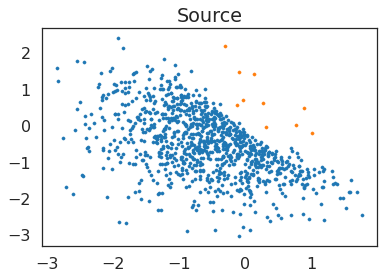

In [381]:
plt.scatter(flow_train_x[:,0].data.cpu().numpy()[y==0], flow_train_x[:,1].data.cpu().numpy()[y==0], s=10)
plt.scatter(flow_train_x[:,0].data.cpu().numpy()[y==1], flow_train_x[:,1].data.cpu().numpy()[y==1], s=10)
plt.title('Source')

Text(0.5, 1.0, 'Source + Target')

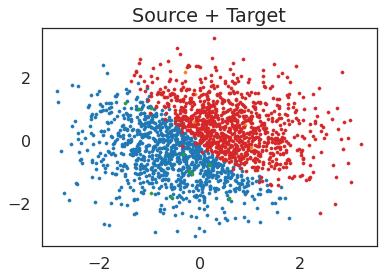

In [382]:
plt.scatter(flow_train_x[:,0].data.cpu().numpy()[y==0], flow_train_x[:,1].data.cpu().numpy()[y==0], s=10)
plt.scatter(flow_train_x[:,0].data.cpu().numpy()[y==1], flow_train_x[:,1].data.cpu().numpy()[y==1], s=10)
# plt.title('Source')
plt.scatter(flow_test_x[:,0].data.cpu().numpy()[u==0], flow_test_x[:,1].data.cpu().numpy()[u==0], s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy()[u==1], flow_test_x[:,1].data.cpu().numpy()[u==1], s=10)

plt.title('Source + Target')

Text(0.5, 1.0, 'Target')

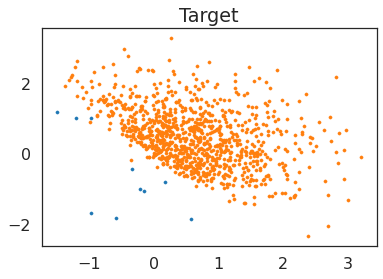

In [383]:
plt.scatter(flow_test_x[:,0].data.cpu().numpy()[u==0], flow_test_x[:,1].data.cpu().numpy()[u==0], s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy()[u==1], flow_test_x[:,1].data.cpu().numpy()[u==1], s=10)
plt.title('Target')

In [384]:
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.05)
clf.fit(flow_train_x.data.cpu().numpy(), y, flow_test_x.data.cpu().numpy())
pred_adapt = clf.predict(flow_test_x.data.cpu().numpy())

     pcost       dcost       gap    pres   dres
 0:  5.1211e+02 -3.2215e+04  3e+04  7e-17  1e+03
 1:  5.0198e+02 -3.1286e+03  4e+03  3e-17  1e+02
 2:  4.8248e+02  3.3678e+02  1e+02  4e-17  2e-14
 3:  4.8082e+02  4.7912e+02  2e+00  2e-16  9e-15
 4:  4.8077e+02  4.8075e+02  2e-02  5e-16  1e-14
 5:  4.8077e+02  4.8077e+02  2e-04  6e-16  1e-14
Optimal solution found.


In [385]:
print('Error adapt in z-space: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt in z-space: 0.317


In [386]:
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())

In [387]:
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())

In [388]:
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.333


-------

# What if we try a slightly different dataset?

In [55]:
import numpy as np
import numpy.random as rnd

from sklearn.linear_model import LogisticRegression
from libtlda.iw import ImportanceWeightedClassifier

"""Generate synthetic data set"""

# Sample sizes
N = 1000
M = 1000

# Class properties
labels = [0, 1]
nK = 2

# Dimensionality
D = 2

In [177]:
# source domain
p = np.random.randn(N,2)
q = np.random.randn(M,2) + 3

In [196]:
split = int(N * .01)
split

10

In [197]:
# source
X = np.vstack([
    q[0:split],
    p[split:]
])
y = np.hstack([
    np.ones(split),
    np.zeros(N - split)
])

In [198]:
# target
Z = np.vstack([
    q[split:],
    p[0:split]
])
u = np.hstack([
    np.ones(N - split),
    np.zeros(split)
])

In [307]:
Z_test = np.vstack([
    np.random.randn(990,2) + 3,
    np.random.randn(10,2)
])
u_test = np.hstack([
    np.ones(990),
    np.zeros(10)
])

In [199]:
X.shape

(1000, 2)

In [200]:
Z.shape

(1000, 2)

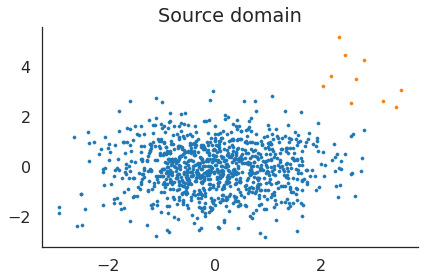

In [201]:
plt.scatter(X[:,0][y==0], X[:,1][y==0], s=10)
plt.scatter(X[:,0][y==1], X[:,1][y==1], s=10)

plt.title('Source domain')
sns.despine()
plt.tight_layout()

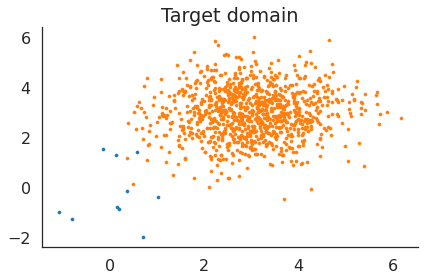

In [202]:
plt.scatter(Z[:,0][u==0], Z[:,1][u==0], s=10)
plt.scatter(Z[:,0][u==1], Z[:,1][u==1], s=10)

plt.title('Target domain')
sns.despine()
plt.tight_layout()

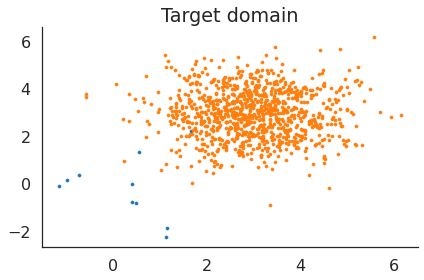

In [308]:
plt.scatter(Z_test[:,0][u_test==0], Z_test[:,1][u_test==0], s=10)
plt.scatter(Z_test[:,0][u_test==1], Z_test[:,1][u_test==1], s=10)

plt.title('Target domain')
sns.despine()
plt.tight_layout()

In [296]:
# Train via KMM
clf = ImportanceWeightedClassifier(weight_estimator='kmm', bandwidth=0.05)
clf.fit(X, y, Z)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

     pcost       dcost       gap    pres   dres
 0:  5.0651e+02 -3.2215e+04  3e+04  3e-16  1e+03
 1:  4.9657e+02 -3.1302e+03  4e+03  1e-16  1e+02
 2:  4.7733e+02  3.3102e+02  1e+02  3e-16  2e-14
 3:  4.7575e+02  4.7414e+02  2e+00  6e-16  5e-15
 4:  4.7570e+02  4.7568e+02  2e-02  2e-16  1e-14
 5:  4.7570e+02  4.7570e+02  2e-04  3e-16  2e-14
Optimal solution found.
Error naive: 0.256
Error adapt: 0.218


In [309]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

In [310]:
# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.269
Error adapt: 0.224


In [311]:
# # can we save this data?
# np.savez('/atlas/u/kechoi/multi-fairgen/data/kmm/source', **{'x': X, 'y': y})
# np.savez('/atlas/u/kechoi/multi-fairgen/data/kmm/target', **{'x': Z, 'y': u})
np.savez('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test', **{'x': Z_test, 'y': u_test})

In [226]:
np.vstack([X,Z]).shape

(2000, 2)